In [1]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

In [12]:
# Global Variables
BATCH_SIZE = 16
IMG_SIZE = 299

In [13]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))
class_names = train_dataset.class_names

Found 16000 files belonging to 8 classes.
Found 16000 files belonging to 8 classes.


In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [17]:
# Freeze the model
base_model.trainable = False

# Adding a classification head
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_max_layer(feature_batch)

In [18]:
# Add a dense layer to convert it to a single prediction per image
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Add the preprocessing layer
x = preprocess_input(inputs)
# Add the base model after, keeping training to false
x = base_model(x, training=False)
# Add max pooling layer
x = global_max_layer(x)
# Add dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Add softmax prediction layer
outputs = prediction_layer(x)
# Create a model from inputs, outputs.
model = tf.keras.Model(inputs, outputs)

In [19]:
# Compile the model
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=10,
                    validation_data=validation_dataset,
                    validation_steps=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 759ms/step - accuracy: 0.1305 - loss: 9.7236 - val_accuracy: 0.1250 - val_loss: 8.3715
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 615ms/step - accuracy: 0.1179 - loss: 9.5385 - val_accuracy: 0.1000 - val_loss: 10.4272
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 614ms/step - accuracy: 0.1212 - loss: 9.7223 - val_accuracy: 0.1063 - val_loss: 13.8842
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 613ms/step - accuracy: 0.0707 - loss: 12.1764 - val_accuracy: 0.1063 - val_loss: 13.5656
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.1158 - loss: 15.9854 - val_accuracy: 0.1375 - val_loss: 12.3536
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 615ms/step - accuracy: 0.1433 - loss: 11.5941 - val_accuracy: 0.1375 - val_loss: 15.6651
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 612ms/step - accuracy: 0.1763 - loss: 12.4706 - val_accuracy: 0.1875 - val_loss: 12.7166
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step - accuracy: 0.1837 - loss: 15.3487 - val_a

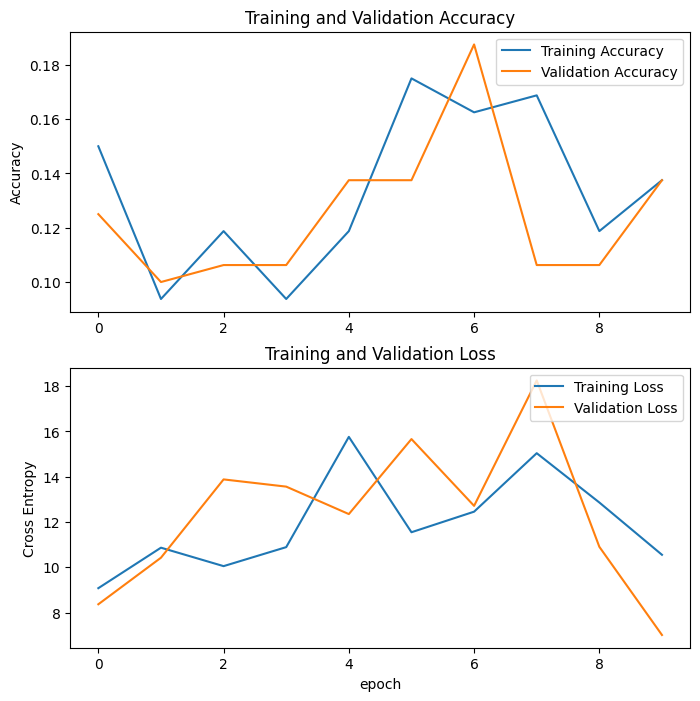

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 323ms/step - accuracy: 0.1240 - loss: 7.1136
Test accuracy : 0.11812499910593033
